In [1]:
from importlib import reload
import time

import numpy as np
import scipy as sc
import pandas as pd

import mbo
import oracles as ora
import util
import searchmodels as sm

import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook");
sns.set_style("darkgrid");

Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


In [168]:
def ground_truth_fn(X_nxm, dim=20):
    mean1 = np.zeros((dim))
    mean1[0] = 5
    mean2 = np.zeros((dim))
    mean2[0] = 7
    cov1 = np.eye(dim)
    cov2 = 0.25 * np.eye(dim)
    pdf1 = np.array([sc.stats.multivariate_normal.pdf(X_m, mean=mean1, cov=cov1) for X_m in X_nxm])
    pdf2 = np.array([sc.stats.multivariate_normal.pdf(X_m, mean=mean2, cov=cov2) for X_m in X_nxm])
    return (pdf1 + pdf2) * np.power(10, dim)

def get_training_data(n, dim=20, seed=None):
    np.random.seed(seed)
    mean = np.zeros((dim))
    mean[0] = 3
    cov = np.eye(dim)
    X_nxm = np.random.multivariate_normal(mean, cov, size=n)
    return X_nxm

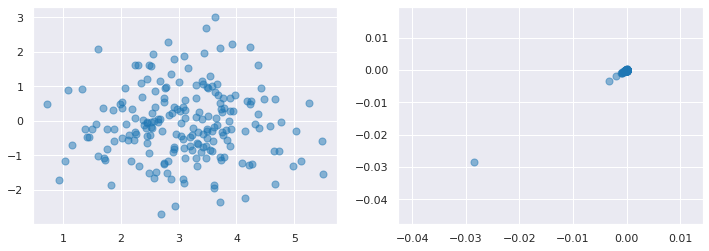

In [169]:
dim = 40
n_train = 200
label_std = 0.0001


mean = np.zeros((dim))
mean[0] = 3
cov = np.eye(dim)
init_sm = sm.MultivariateGaussian(dim)
init_sm.set_parameters((mean, cov))

Xo_nxm, _ = init_sm.sample(n_train)
gtnn_n = ground_truth_fn(Xo_nxm, dim=dim)
noise_n = label_std * np.random.randn(n_train)
gto_n = gtnn_n + noise_n
  
plt.figure(figsize=(12, 4));
plt.subplot(121)
plt.scatter(Xo_nxm[:, 0], Xo_nxm[:, 1], s=50, alpha=0.5);
plt.subplot(122)
plt.scatter(gtnn_n, gto_n, s=50, alpha=0.5);

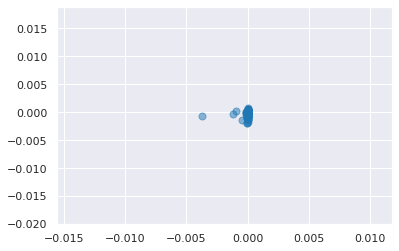

In [170]:
reload(ora)
n_test = 100
oracle = ora.KernelRidgeRegression()
oracle.fit(Xo_nxm, gto_n)
Xtest_nxm, _ = init_sm.sample(n_test)
gttest_n = ground_truth_fn(Xtest_nxm, dim=dim)
predm_n, predv_n = oracle.predict(Xtest_nxm)
plt.scatter(gttest_n, predm_n, s=50, alpha=0.5);

In [173]:
reload(ora)
reload(sm)
reload(mbo)
cbas = mbo.ConditioningByAdaptiveSampling(quantile=0.9)
traj_noaf = cbas.run(Xo_nxm, gto_n, lambda x: ground_truth_fn(x, dim=dim),
                oracle, init_sm, autofocus=False, iw_alpha=0.2,
                n_iter=20, n_sample=n_train, update_strf='{:.3f}')
traj_af = cbas.run(Xo_nxm, gto_n, lambda x: ground_truth_fn(x, dim=dim),
                oracle, init_sm, autofocus=True, iw_alpha=0.2,
                n_iter=20, n_sample=n_train, update_strf='{:.3f}')

Initialization. Oracle 80-th percentile: 0.00. Ground truth median/max in training data: -0.00, 0.00
Oracle value of ground-truth max: -0.00
Iter 0. Oracle 80-th percentile: 0.000. Ground-truth median/max of top candidates: -0.000, -0.000
Iter 1. Oracle 80-th percentile: 0.000. Ground-truth median/max of top candidates: -0.000, -0.000
Iter 2. Oracle 80-th percentile: 0.000. Ground-truth median/max of top candidates: -0.000, -0.000
Iter 3. Oracle 80-th percentile: 0.000. Ground-truth median/max of top candidates: -0.000, -0.000
Iter 3. No sample weights surpassed 1e-08.
Initialization. Oracle 80-th percentile: 0.00. Ground truth median/max in training data: -0.00, 0.00
Oracle value of ground-truth max: -0.00
Iter 0. Oracle 80-th percentile: 0.000. Ground-truth median/max of top candidates: -0.000, -0.000
Iter 1. Oracle 80-th percentile: 0.000. Ground-truth median/max of top candidates: -0.000, -0.000
Iter 2. Oracle 80-th percentile: -0.001. Ground-truth median/max of top candidates: -0.

[0.15215306 0.15850027 0.79142879 0.02679335]
[0.14511834 0.15910904 0.74097502 0.05549481]


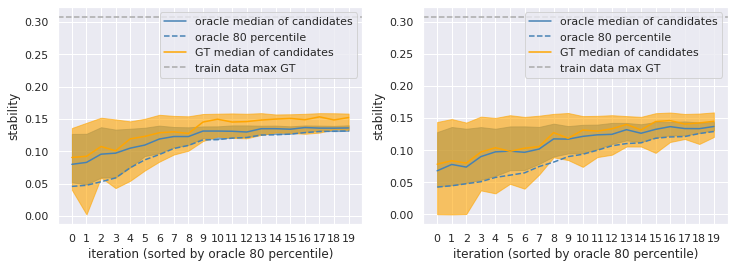

In [157]:
seed = 5

oracleaf_txm = traj_af.oracle_txm
gtaf_txm = traj_af.gt_txm
iwaf_txn = traj_af.iw_txn
seaf_txm = traj_af.se_txm
gt0af_n = traj_af.gt0_n
oracle_txm = traj_noaf.oracle_txm
gt_txm = traj_noaf.gt_txm
se_txm = traj_noaf.se_txm
gt0_n = traj_noaf.gt0_n

perc = 80
perc_low = 5
perc_high = 95
o_c = "steelblue"
gt_c = "orange"
alpha = 0.6

scores, scores_af = util.score_top_candidates(oracle_txm, gt_txm, oracleaf_txm, gtaf_txm, perc)
print(scores[1 :])
print(scores_af[1 :])

plt.figure(figsize=(12, 4));
plt.subplot(121)
cands_t = [util.get_promising_candidates(o_m, gt_m, percentile=perc)
           for o_m, gt_m in zip(oracle_txm, gt_txm)]
ocand_t, gtcand_t, operc_t = list(zip(*cands_t))
operc_t = np.array(operc_t)
ocandmed_t = np.array([np.median(ocand) for ocand in ocand_t])
idx = np.argsort(operc_t)
gtcandmed_t = np.array([np.median(gtcand) for gtcand in gtcand_t])
ocandlow_t = np.array([np.percentile(ocand, perc_low) for ocand in ocand_t])
gtcandlow_t = np.array([np.percentile(gtcand, perc_low) for gtcand in gtcand_t])
ocandhigh_t = np.array([np.percentile(ocand, perc_high) for ocand in ocand_t])
gtcandhigh_t = np.array([np.percentile(gtcand, perc_high) for gtcand in gtcand_t])

x = range(20)
plt.plot(x, ocandmed_t[idx], c=o_c, label="oracle median of candidates");
plt.plot(x, operc_t[idx], "--", c=o_c, label="oracle {} percentile".format(perc));
plt.plot(x, gtcandmed_t[idx], c=gt_c, label="GT median of candidates");
plt.axhline(np.max(gt0_n), linestyle="--", c="darkgray", label="train data max GT");
plt.fill_between(x, ocandlow_t[idx], ocandhigh_t[idx], alpha=alpha, color=o_c);
plt.fill_between(x, gtcandlow_t[idx], gtcandhigh_t[idx], alpha=alpha, color=gt_c);
plt.legend();
plt.xlabel('iteration (sorted by oracle {} percentile)'.format(perc));
plt.ylabel('stability');
plt.xticks(x); # plt.ylim([0.05, 0.4]);

plt.subplot(122)
cands_t = [util.get_promising_candidates(o_m, gt_m, percentile=perc)
           for o_m, gt_m in zip(oracleaf_txm, gtaf_txm)]
ocand_t, gtcand_t, operc_t = list(zip(*cands_t))
operc_t = np.array(operc_t)
ocandmed_t = np.array([np.median(ocand) for ocand in ocand_t])
idx = np.argsort(operc_t)
gtcandmed_t = np.array([np.median(gtcand) for gtcand in gtcand_t])
ocandlow_t = np.array([np.percentile(ocand, perc_low) for ocand in ocand_t])
gtcandlow_t = np.array([np.percentile(gtcand, perc_low) for gtcand in gtcand_t])
ocandhigh_t = np.array([np.percentile(ocand, perc_high) for ocand in ocand_t])
gtcandhigh_t = np.array([np.percentile(gtcand, perc_high) for gtcand in gtcand_t])

plt.plot(x, ocandmed_t[idx], c=o_c, label="oracle median of candidates");
plt.plot(x, operc_t[idx], "--", c=o_c, label="oracle {} percentile".format(perc));
plt.plot(x, gtcandmed_t[idx], c=gt_c, label="GT median of candidates");
plt.axhline(np.max(gt0af_n), linestyle="--", c="darkgray", label="train data max GT");
plt.fill_between(x, ocandlow_t[idx], ocandhigh_t[idx], alpha=alpha, color=o_c);
plt.fill_between(x, gtcandlow_t[idx], gtcandhigh_t[idx], alpha=alpha, color=gt_c);
plt.legend();
plt.xlabel('iteration (sorted by oracle {} percentile)'.format(perc));
plt.ylabel('stability');
plt.xticks(x); # plt.ylim([0.05, 0.4]);